## Cabeza de auto-atención

En los transformadores se suelen utilizar diferentes cabezas de atención para procesar los datos de entrada. Una cabeza de atención es simplemente la aplicación de una capa de atención aplicada a los datos de entrada ya codificados por medio de los embeddings y la codificación posicional. Dentro de la red que construiremos se contará entonces con los siguientes elementos:

1. Embeddings y codificación posicional: Representarán los datos en formato vectorial para que pueden entrar dentro de las cabezas de auto-atención.
2. Cabeza de auto-atención: Representa los datos a partir de la auto-atención como $h_i = \sum_j \alpha(x_i, x_j) \psi_v(x_j)$.
3. Suma y normalización: Normaliza los datos con normalización de lote y suma capas previas de manera residual.
4. Feedforward: Finalmente, aplica una capa de red feedforward con activación ReLU. Esta capa puede verse como $$x_i = W ReLU(W'h_i + b') + b$$ donde $W$ y $W'$ son pesos, $b$ y $b'$ los bias y $ReLU(x) = \max\{0, x\}$.

El resultado de todo este proceso genera nuevos vectores que representan a la entrada. Dentro del transformador, el proceso que estamos describiendo corresponde al codificador con una sola cabeza de atención. Una sola cabeza de atención realiza la operación de auto-atención como se ha revisado <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/02SelfAttention.html">previamente</a>. Ilustramos la forma en que construimos el módulo:

<img src="images/AttHead.png" width="380" class="center">

Considereamos sólo una cabeza de atención que se conforma de la proyección hacia el espacio de queries, keys y values; las dos primeras se multiplican para obtener los pesos de atención con ayuda de softmax, y con esto se hace la suma convexa de los valores para obtener las nuevas representaciones.

In [1]:
import torch
import torch.nn as nn
from transformers import *

class AttentionModule(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, dropout=0.3):
        super(AttentionModule, self).__init__()
        self.d_model = d_model
        #Embedding y codificación posicional
        self.enc = Encoding(in_size, d_model)
        #Auto-atención
        self.att = SelfAttention(d_model)
        #Normalización
        self.norm = LayerNorm(d_model)
        #Red feedforward
        self.ffw = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        #Dropouts
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x_e = self.enc(x)
        h, self.p_mat = self.att(self.drop1(x_e))
        h_norm = x_e + self.norm(h)
        out = self.ffw(self.drop2(h))
        
        return h_norm + self.norm(out)

### Ejemplo de aplicación

Para aplicar el módulo con uso de una cabeza de auto-atención definimos un problema sencillo orientado a la estimación de un modelo del lenguaje. Utilizamos un ejemplo de juguete para este caso, de tal forma que sea muy sencillo el entrenamiento y la evaluación. En la práctica se suelen usar ejemplos de mayor complejidad y con una cantidad inmesa de datos para entrenar este tipo de modelos del lenguaje.

Los datos textuales son procesados para obtener vectores de índices. Estos vectores se pasan a formato torch y se crean los datos de entrenamiento. El objetivo es predecir el tóken siguiente dado el anterior. Para esto, los pares de entrenamiento consisten en las cadenas de entrada alineadas en un tóken siguiente. Esto es, la predicción que buscamos es como:

$$[bos] w_1 w_2 ... w_n \mapsto w_1 w_2 ... w_n [eos]$$

Donde los símbolos especiales [bos] y [eos] indican inicio y final de cadena, respectivamente. Por tanto, en cada tóken se busca predecir el siguiente. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap as hm
from tqdm import tqdm

#Corpus a utilizar
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 
          'un gato come', 'un muchacho jugaba con la cuerda', 'el muchacho jugaba con la cuerda']
corpus = [w.split() for w in corpus]
#Creación del vocabulario
voc = vocab()
voc['[bos]'] = 0
voc['[eos]'] = 1
#Indexación de cadenas
sents = list(index(corpus, voc))

#Pares de entrenamiento
x = [torch.cat((torch.tensor([voc['[bos]']]),s), axis=0) for s in sents]
y = [torch.cat((s, torch.tensor([voc['[eos]']])), axis=0) for s in sents]
print(x[0], y[0])

tensor([0, 2, 3, 4, 5, 6]) tensor([2, 3, 4, 5, 6, 1])


Generamos, entonces, el modelo que vamos a utilizar. En este caso usaremos el módulo que hemos definido previamente con auto-atención; además, para obtener las probabilidades de predicción en la salida, agregamos una capa lineal con activación Softmax. El resultado serán los vectores de probabilidades de las palabras siguientes. Si hemos guardado un modelo previamente podemos cargarlo.

In [5]:
len_voc = len(voc)
#Modelo
model = nn.Sequential(AttentionModule(len_voc, 128), 
                      nn.Linear(128,len_voc), nn.Softmax(1))
#Carga del modelo
#model.load_state_dict(torch.load('toy.model'))
model.eval()

Sequential(
  (0): AttentionModule(
    (enc): Encoding(
      (emb): Embedding(15, 128)
      (pe): PositionalEncoding()
    )
    (att): SelfAttention(
      (Q): Linear(in_features=128, out_features=128, bias=False)
      (K): Linear(in_features=128, out_features=128, bias=False)
      (V): Linear(in_features=128, out_features=128, bias=False)
    )
    (norm): LayerNorm()
    (ffw): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (drop1): Dropout(p=0.3, inplace=False)
    (drop2): Dropout(p=0.3, inplace=False)
  )
  (1): Linear(in_features=128, out_features=15, bias=True)
  (2): Softmax(dim=1)
)

En caso de no contar con un modelo previo, debemos entrenar el modelo, para esto utilizamos un procedimiento de optimización sencillo, basado en la función objetivo de entropía cruzada y utilizamos el optimizador Adam con regularización. Este no es el método propuesto para el entrenamiento de transformadores, pues para estas arquitecturas se propone el optimizador Noam, que se revisará más adelante. Pero dadas las características sencillas del ejemplo que aquí presentamos simplificamos este paso.

In [6]:
#Función objetivo
loss = nn.CrossEntropyLoss()
#Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01 )
#Núm de épocas
epochs = range(100)

#Entrenamiento
for t in tqdm(epochs):
    for x_i, y_i in zip(x,y):
        prediction = model(x_i)
        optimizer.zero_grad()
        loss_value = loss(prediction, y_i)
        loss_value.backward()
        optimizer.step()
                
#torch.save(model.state_dict(), 'model.model')

/home/cienciasia/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 45.05it/s]


Ya que tenemos un modelo entrenado podemos utilizarlo para predecir las probabilidades de las palabras siguientes. El modelo de lenguaje que hemos propuesto obtiene las probabilidades de la forma:

$$p(w|w_1\cdots w_n)$$

Aquí $w_1\cdots w_n$ es la historia de tókens previos y $w$ es el posible tóken que puede seguir a esta historia. Podemos observar cuáles son las probabilidades dada una cadena de entrada. Asimismo, podemos elegir una palabra entre las palabras con mayor probabilidad.

Palabra siguiente con mayor prob: un


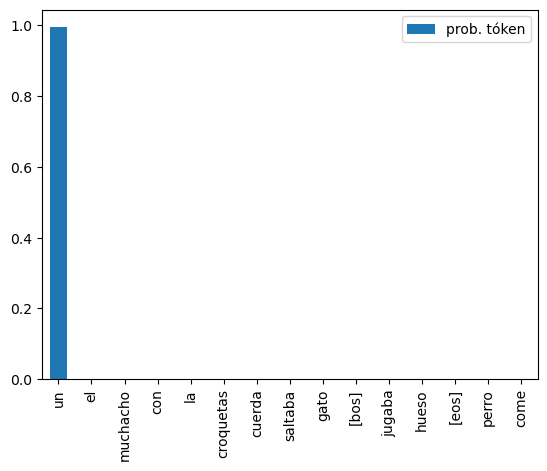

In [7]:
devoc = {i:t for t,i in voc.items()}
def result(text, model):
    #Función para predecir la siguiente palabra dado el contexto
    tokens = text.split()
    x = torch.tensor([voc[t] for t in tokens])
    pred = model(x)
    max_token = pred.argmax(axis=1).detach().numpy()
    
    return pred.detach().numpy(), ' '.join([devoc[i] for i in max_token])

p, pred_text = result('[bos]', model)
print('Palabra siguiente con mayor prob: {}'.format(pred_text))

#Visualización de probabilidades más altas
args = np.argsort(p[-1])[::-1]
probs = np.sort(p[-1])[::-1]
pd.DataFrame(data=probs, columns=['prob. tóken'], index=[devoc[j] for j in args]).plot.bar()
plt.show()

Finalmente, podemos visualizar cómo se comporta el mecanismo de auto-atención en este módulo. Como sólo usamos una cabeza, sólo obtendremos una matriz de atención. En este caso, dado que la tarea es predecir la palabra siguiente, puede verse que los pesos de atención están precisamente determinados por la siguiente palabra, excepto en el último caso. Este es un ejemplo bastante simple, pero nos da cierta idea de cómo trabaja la auto-atención.

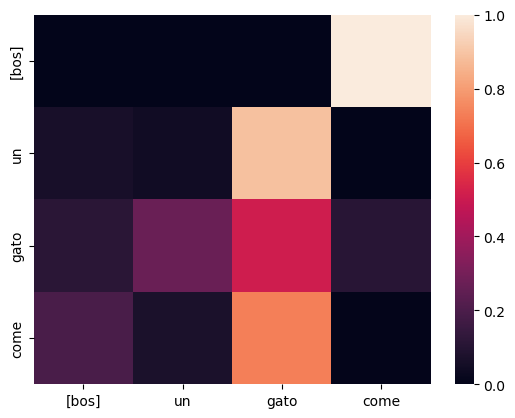

In [8]:
text = '[bos] un gato come'
result(text, model)

hm(model[0].p_mat.detach().numpy(), xticklabels=text.split(), yticklabels=text.split(), vmin=0, vmax=1)
plt.show()

## Atención Multi-cabeza

La arquitectura de los transformadores propone el uso de múltiples cabezas para procesar la información de entrada. El concepto de multi-cabeza busca tener varias psoibles representaciones que capturen diferentes relaciones entre los elementos de entrada del modelo. Para ayudar al modelo a hacer mejores predicciones se pueden utilizar múltiples cabezas, de tal forma que cada cabeza puede aprender un conjunto de relaciones distinto y utilizar ese conjunto de relaciones para poder estimar diferentes representaciones de los datos de entrada. Así cada cabeza se enfocaría a una representación particular, permitiendo una mayor variación en éstas. 

Las múltiples cabezas no se calculan de forma secuencial, como suele hacerse con las capas, sino que se estiman de forma paralela. Es decir, se calculan $N$ veces la auto-atención. Esto implica realizar cada paso de la auto-atención $N$ veces. De tal forma que, para distinguir la cabeza, podemos utilizar un sub-índice:

$$head_i = Att(Q_i, K_i, V_i) = Softmax\Big( \frac{Q_i K_i^T}{\sqrt{d_i}} \Big) V_i$$

Para cada $i \in \{1,2,...,N\}$. Entonces, gneramos $N$ proyecciones de query, key y value. Asimismo, obtenemos $N$ matrices de atención. Esto nos dará un conjunto de $N$ salidas, matrices de $n \times d$ ($n$ elementos de entrada por $d$ dimensión del modelo). Para poder reducir esto a un sólo conjunto de datos, combinamos la salida de cabezal a partir de la concatenación de las salidas de todos los cabezales y multiplicando por una matriz de $N d \times d$. Esto es, la representación final será:

$$h = [head_1 || head_2 || \cdots || head_N] W + (b)$$

Donde $[ \cdot || \cdot]$ es la operación de concatenación y $W \in \mathbb{R}^{Nd \times d}$$. El siguiente diagrama muestra el cómo se realiza esta operación; en éste se observa que se realizan $N$ proyecciones (query, key, value) de los datos de entrada, y que existen $N$ capas paralelas de atención:

<img src="images/multiHead.png" width="350" class="center">

La auto-atención multi-cabeza puede verse como una combinación afín de las representaciones obtenidas en las cabezas de auto-atención. Supongamos que la matriz $W$ tienen $N$ secciones $W_i \in \mathbb{R}^{d\times d}$ tal que $W = [W_1 || W_2 || \cdots || W_N]$$, entonces, la representación de la fórmula anterior puede expresarse como:

$$h = head_1 W_1 + head_2 W_2 + \cdots + head_N W_N + (b)$$

Es decir, la auto-atención multi-cabeza está combinando la representación de las diferetes cabezas por medio de una suma ponderada para obtener una nueve representación que incorpore la información en cada cabeza. Esto en general obtiene mejores representaciones y es el estándar para los modelos de transformadores y los modelos del lenguaje.

Para nuestra implementación multi-cabeza, haremos $N$ copias de la cala de auto-atención (<tt>SelfAttention</tt>) utilizando <tt>nn.ModuleList</tt> de Pytorch. Esto nos permitirá aplicar de forma paralela cada cabeza de auto-atención a los datos. Guardaremos una lista de las diferentes matrices de atención en cada cabeza para observar qué relaciones aprende en cada una.

In [9]:
import copy

class MultiHeadAttention(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, heads=3, dropout=0.3):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        #Embedding y codificación posicional
        self.enc = Encoding(in_size, d_model)
        #Auto-atención
        self.att = nn.ModuleList([copy.deepcopy(SelfAttention(d_model)) for _ in range(heads)])
        #Capa linear para multi cabezas
        self.lin = nn.Linear(heads*d_model, d_model, bias=True)
        #Normalización
        self.norm = LayerNorm(d_model)
        #Red feedforward
        self.ffw = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
        self.drop3 = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x_e = self.enc(x)
        x_e = self.drop1(x_e)
        head_att = [head(x_e) for head in self.att]
        self.att_weights = [head[1] for head in head_att]
        heads = [head[0] for head in head_att]
        multi_heads = torch.cat(heads, dim=-1)
        h = self.lin(multi_heads)
        h_norm = x_e + self.norm(h)
        h_norm = self.drop2(h_norm)
        out = self.ffw(h)
        
        return self.drop3(h_norm + self.norm(out))

Ya que hemos definido nuestro módulo multi-cabeza, generamos el modelo. Al igual que en el caso anterior definiremos una capa de salida con activación Softmax. La dimensión del modelo será igual que el anteriro (128), pero ahora usaremos 5 cabezas. Si el modelo ya ha sido entrenado previamente lo cargaremos.

In [11]:
model_heads = nn.Sequential(MultiHeadAttention(len_voc, 128, heads=3), 
                      nn.Linear(128,len_voc), nn.Softmax(1)) 

#Carga del modelo
#model_heads.load_state_dict(torch.load('headx3.model'))
model_heads.eval()

Sequential(
  (0): MultiHeadAttention(
    (enc): Encoding(
      (emb): Embedding(15, 128)
      (pe): PositionalEncoding()
    )
    (att): ModuleList(
      (0-2): 3 x SelfAttention(
        (Q): Linear(in_features=128, out_features=128, bias=False)
        (K): Linear(in_features=128, out_features=128, bias=False)
        (V): Linear(in_features=128, out_features=128, bias=False)
      )
    )
    (lin): Linear(in_features=384, out_features=128, bias=True)
    (norm): LayerNorm()
    (ffw): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (drop1): Dropout(p=0.3, inplace=False)
    (drop2): Dropout(p=0.3, inplace=False)
    (drop3): Dropout(p=0.3, inplace=False)
  )
  (1): Linear(in_features=128, out_features=15, bias=True)
  (2): Softmax(dim=1)
)

Si no hemos entrenado el modelo con anterioridad, podemos entrenarlo. Al igual que en el ejemplo de una sola cabeza, utilizamos un entrenamiento sencillo con el optimizador Adam, y función objetivo de entropía cruzada. Entrenamos ejemplo por ejemplo con 100 épocas. 

In [12]:
#Función objetivo
loss = nn.CrossEntropyLoss()
#Optimizador
optimizer = torch.optim.Adagrad(model_heads.parameters(), lr=0.01, weight_decay=0.001 )
#Núm de épocas
epochs = range(100)

#Entrenamiento
for t in tqdm(epochs):
    for i in torch.randperm(len(x)):
        prediction = model_heads(x[i])
        optimizer.zero_grad()
        loss_value = loss(prediction, y[i])
        loss_value.backward()
        optimizer.step()
        
#torch.save(model_heads.state_dict(), 'model.model')

100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.70it/s]


Ya que hemos obtenido nuestro modelo entrenado, podemos probar cómo trabaja con datos específicos. La salida del modelo multi-cabeza no muestra variaciones con respecto al modelo d euna cabeza; es decir, se obtiene la probabilida de una palabra dado lo anterior $p(w|w_1 \cdots w_n)$. Lo que cambia es la forma en que esta probabilidad se obtiene y, por tanto, las probabilidades también pueden variar pues las representaciones internas con las que el modelo trabaja son diferentes.

Palabra siguiente con mayor prob: un


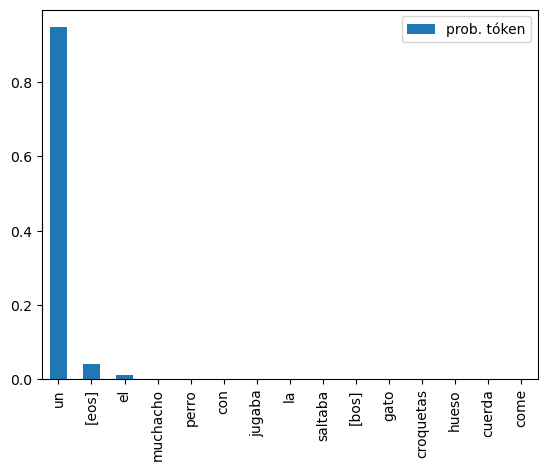

In [13]:
p, pred_text = result('[bos]', model_heads)
print('Palabra siguiente con mayor prob: {}'.format(pred_text))

#Visualización de probabilidades más altas
args = np.argsort(p[-1])[::-1]
probs = np.sort(p[-1])[::-1]
pd.DataFrame(data=probs, columns=['prob. tóken'], index=[devoc[j] for j in args]).plot.bar()
plt.show()

Dado el modelo, podemos observar lo que aprende en cada cabeza de atención. En este caso, como hemos usado $N$ cabezas de atención, tendremos $N$ matrices con pesos de atención. Podemos ver que en cada una de estas se pueden presentar diferentes relaciones entre los elementos de entrada. De tal forma que la representación final considerará estas relaciones.

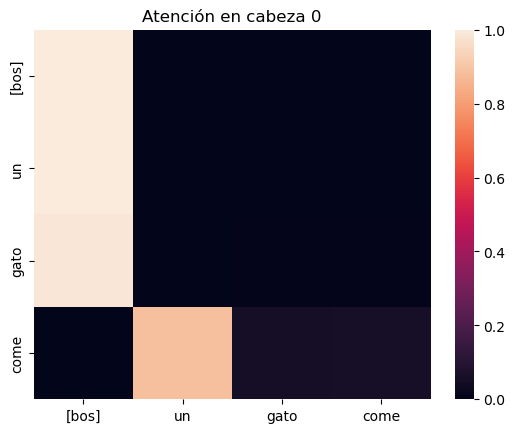

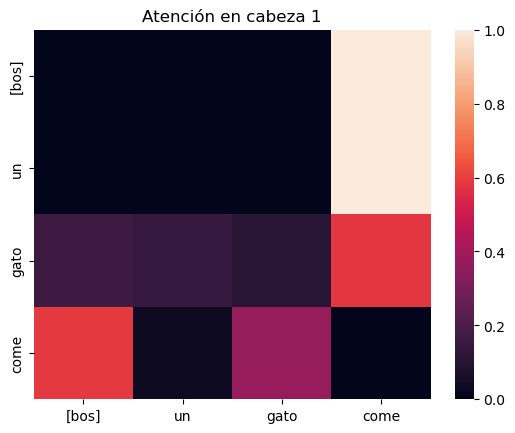

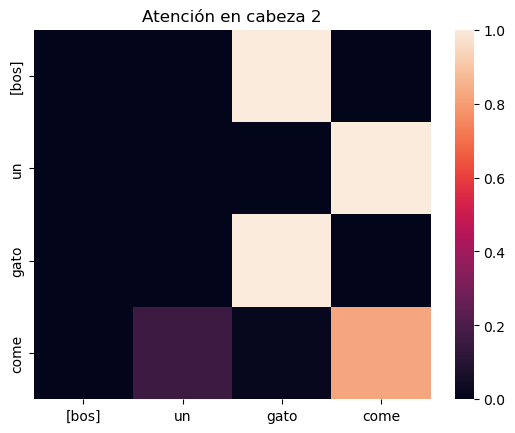

In [14]:
text = '[bos] un gato come'
result(text, model_heads)

for i, att_w in enumerate(model_heads[0].att_weights):
    hm(att_w.detach().numpy(), xticklabels=text.split(), yticklabels=text.split(), vmin=0, vmax=1)
    plt.title('Atención en cabeza %i' %i)
    plt.show()

### Otras propuestas de multi-cabeza

Otras propuestas se han realizado para realizar la operación de las multi-cabezas. En la versión propuesta por Vaswabi et ak. (2017) las cabezas de atención trabajan de manera independiente. En contrates con esto, Cordonnier et al. (2020) proponen un conjunto de cabezas de atención colaborativas. Estas cabezas utilizan una sola proyección hacia los espacios de query y key, y $N$ proyecciones hacia el espacio de values. Es decir, se tiene sólo una matriz de query $W_q$ y una sola de key $W_k$. De tal forma que las matrices $Q$ y $K$ son únicas. Pero las matrices de value son $N$, $V_i$. 

Para realizar diferentes matrices de atención en las diferentes cabezas, se crea una matriz diagonal $M \in \mathbb{R}^{d\times d}$ que realiza diferentes productos puntos. De tal forma que la atención colaorativa define las siguientes cabezas:

$$head_i = Att(Q M, K, V_i) = Softmax\Big( \frac{Q M K^T}{\sqrt{d}} \Big) V_i$$

En este sentido, el producto punto está determinado como:

$$(Q S K^T)_{i,j} = \sum_l m_l \phi_q(x_i)_l \phi_k(x_j)_l$$

Es decir, el produco entre cada vector de proyección está ponderado por los valores $m_1,...,m_d$ que dependen de la cabeza actual. De esta forma, en lugar de aprender $N$ matrices de query y $N$ de keys, se aprende sólo un vector de los valores de la diagonal en $M_i$.

## Referencias

Cordonnier, J. B., Loukas, A., & Jaggi, M. (2020). Multi-head attention: Collaborate instead of concatenate. arXiv preprint arXiv:2006.16362.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). <it>Attention is all you need. Advances in neural information processing systems</it>, 30.

-----------------------------------------------------------------------

<a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/">Principal</a>